In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import keras
from keras import layers, models
from keras.layers import Dense

In [6]:
authentication_data = pd.read_csv('https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/raw/main/Data/Authentication%20data.gz', compression='gzip', index_col = 0)

/Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Otherwise use sorting


In [12]:
rt_usernames = list(pd.read_csv('https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/raw/main/Data/AuthUserNames.txt', header=None)[0])


In [7]:
# splits a dataframe into n chunks
def split_dataframe(df,n): 
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

In [9]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n

    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type').size()
                auth_type_df[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())

    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

In [32]:
df = auth_type_un_df(rt_usernames[0],24)
rank_2 =  np.array(df)
rank_3 = tf.stack([rank_2[i:i+23] for i in np.arange(0,len(rank_2)-1,24)])

npad = ((0, 0), (1, 0), (1, 0))    
rank_3 = np.pad(rank_3, pad_width=npad, mode='constant', constant_values=0)


In [58]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.models import Model


input_img = Input(shape=(24, 14, 1)) 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(metrics=['accuracy'], optimizer='adam', loss='mse')

In [59]:
autoencoder.fit(rank_3[:57], rank_3[:57], epochs=10, batch_size=256)

Epoch 1/10
1/1 [==============================] - 1s 884ms/step - loss: 0.2485 - accuracy: 0.8815
Epoch 2/10
1/1 [==============================] - 0s 50ms/step - loss: 0.2464 - accuracy: 0.8966
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 0.2445 - accuracy: 0.9064
Epoch 4/10
1/1 [==============================] - 0s 41ms/step - loss: 0.2424 - accuracy: 0.9170
Epoch 5/10
1/1 [==============================] - 0s 49ms/step - loss: 0.2403 - accuracy: 0.9299
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 0.2381 - accuracy: 0.9339
Epoch 7/10
1/1 [==============================] - 0s 33ms/step - loss: 0.2358 - accuracy: 0.9377
Epoch 8/10
1/1 [==============================] - 0s 85ms/step - loss: 0.2336 - accuracy: 0.9489
Epoch 9/10
1/1 [==============================] - 0s 46ms/step - loss: 0.2312 - accuracy: 0.9598
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.2289 - accuracy: 0.9645


In [60]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 24, 14, 1)]       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 24, 14, 32)        320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 7, 32)         0         
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 24, 14, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 24, 14, 1)         289       
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [67]:
reconstruction = autoencoder.predict(np.array(rank_3[79]).reshape(1,24,14))

In [69]:
error_list = []
for i in range (33):
    reconstruction = autoencoder.predict(np.array(rank_3[57+i]).reshape(1,24,14))
    reconstruction = reconstruction.reshape(1, 24, 14)
    error = np.mean(np.power(np.array(rank_3[57+i]).reshape(1,24,14)-reconstruction, 2))
    error_list.append(error)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f81477bf280>,
 'caps': [<matplotlib.lines.Line2D at 0x7f81477bff40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f81480a1bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f814808e970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f814808e250>],
 'means': []}

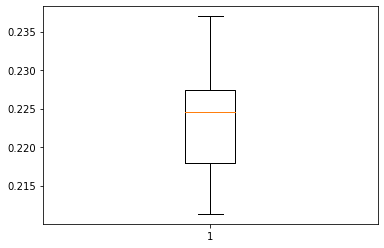

In [70]:
plt.boxplot(error_list)